For reference, take a look at https://colab.research.google.com/drive/1ZZXnCjFEOkp_KdNcNabd14yok0BAIuwS#forceEdit=true&sandboxMode=true&scrollTo=ibuJZqAXQrWJ

The terms deep learning and neural networks are used interchangeably because all deep learning systems are made of neural networks. However, technical details vary. There are several different types of neural network technology, and all may not be used in deep learning systems.

In a simple neural network, every node in one layer is connected to every node in the next layer. There is only a single hidden layer.

In contrast, deep learning systems have several hidden layers that make them deep.

There are two main types of deep learning systems with differing architectures—convolutional neural networks (CNNs) and recurrent neural networks (RNNs).

In the fashion NIST previously, we worked with a simple neural network instead

Dense Layer: A dense layer will consider the ENTIRE image. It will look at all the pixels and use that information to generate some output.

Convolutional Layer: The convolutional layer will look at specific parts of the image. In this example let's say it analyzes the highlighted parts below and detects patterns there. 

The dataset we will use is built into tensorflow and called the CIFAR Image Dataset. It contains 60,000 32x32 color images with 6000 images of each class.

The labels in this dataset are the following:

- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt 

In [3]:
#  LOAD AND SPLIT DATASET
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 542s 3us/step


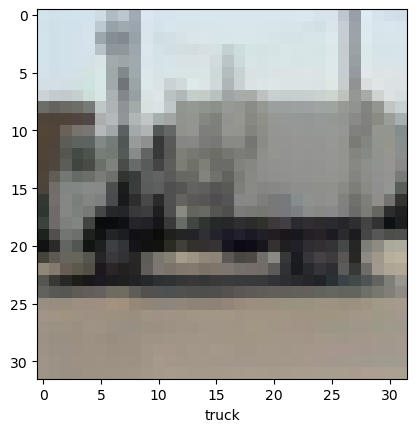

In [13]:
IMG_idx = 49534


plt.imshow(train_images[IMG_idx], cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_idx][0]])
plt.show()

Now let us look at the CNN architecture

A common architecture for a CNN is a stack of Conv2D and MaxPooling2D layers followed by a few denesly connected layers. To idea is that the stack of convolutional and maxPooling layers extract the features from the image. Then these features are flattened and fed to densly connected layers that determine the class of an image based on the presence of features.

Layer 1

The input shape of our data will be 32, 32, 3 and we will process 32 filters of size 3x3 over our input data. We will also apply the activation function relu to the output of each convolution operation.

Layer 2

This layer will perform the max pooling operation using 2x2 samples and a stride of 2.

Other Layers

The next set of layers do very similar things but take as input the feature map from the previous layer. They also increase the frequency of filters from 32 to 64. We can do this as our data shrinks in spacial dimensions as it passed through the layers, meaning we can afford (computationally) to add more depth.

In [ ]:
#This is going to be the convolutional base!

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2))) # takes the 32 feature maps from the line above and reduces their size by taking max value in each 2x2 window
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #we dont need to put input shape for this one and the one below becuase it will figure it out based on the input from the first layer
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #also, note that we can get 64 layers in this and 2nd layer becuase maxpool reduces size of the first 32 feature maps

#FYI, it’s common in CNNs to start with fewer filters and increase them in deeper layers, as the model needs to represent more complex features.

/Users/dev/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The whole point of the above part is the shrink the size of the feature map by a factor of two and return a response map that is 2x smaller.

In [16]:
model.summary()  # let's have a look at our model so far

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In the above result, first of all notice how the first output shape is no longer 32x32x32. Instead we have 30x30x32 (height, width, channels) because we did the sampling without padding (a virtual addiiton of pixels on the edges of our images) - so 2 pixels less becuase of the amount of pixels we can take. That also happens when we do the two other conv_2d calls.

So now, we must use the last output shape of (4,4,64) which is a result of the extraction of all the important features in our image. We take it and put it through a dense layer classifier that helps us which combinationa of these features maps to one of the 1- classes (labels)

In [19]:
model.add(layers.Flatten()) #this takes that final 64 4x4 feature maps and puts it into a straight line
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Basically what the first 'layers.dense' did was create a 64 neuron dense layer that connects all the flattened layer. 

The second 'layers.dense' then created an output layer - 10 because we have 10 classes that our object has to be a part of

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Now just as we did when we classified Fashion MNIST, we also have to define the loss function, optimizer and metrics we would like to track.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Lets train the model

In [23]:
history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels))

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.3638 - loss: 1.7280 - val_accuracy: 0.5490 - val_loss: 1.2675
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5801 - loss: 1.1809 - val_accuracy: 0.6385 - val_loss: 1.0331
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6442 - loss: 1.0127 - val_accuracy: 0.6476 - val_loss: 1.0062
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6856 - loss: 0.9003 - val_accuracy: 0.6613 - val_loss: 0.9531


And just like MNIST fashion classification, we can evaluate our model with testing data instead of training data. But this time notice for the above code (training the model) we have validationd data set to test data. The below will do the same as that part! But lets do it nonetheless

In [28]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

313/313 - 1s - 3ms/step - accuracy: 0.6613 - loss: 0.9531
0.661300003528595


In [32]:
predictions = model.predict(test_images)

print(class_names[np.argmax(predictions[4500])])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
cat


It is indeed a cat!

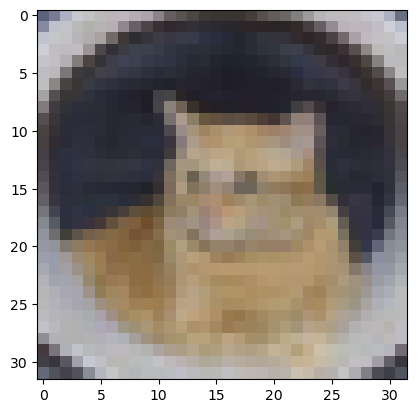

In [37]:
plt.figure()
plt.imshow(test_images[4500])

plt.grid(False)
plt.show()

What would be useful is to manipulate each of our images in slighlty different ways - perhaps stretchi. Let using, shifitng, or rotating it. This would give our model a chance to see more varied instances of the same image. This is called data augmentation. Let us now proceed to do that

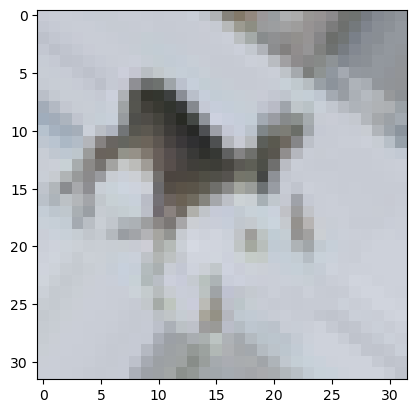

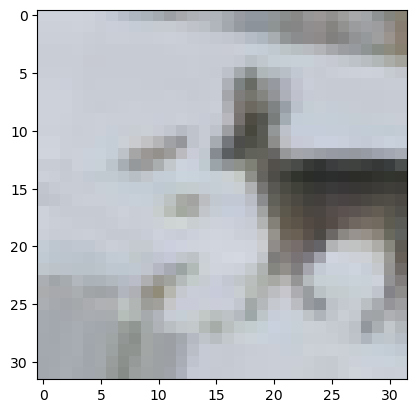

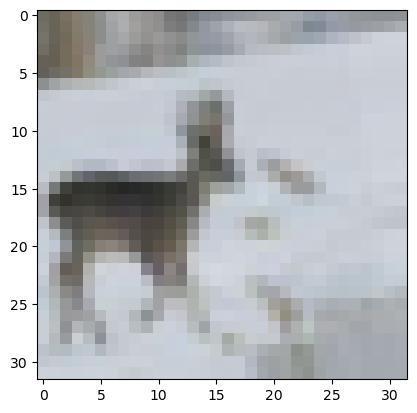

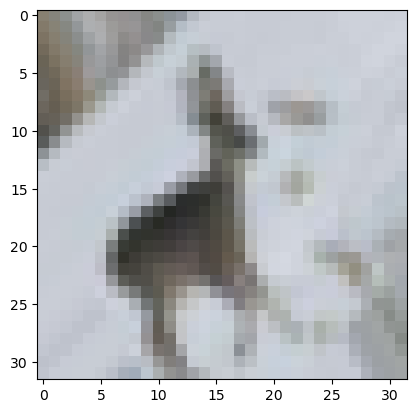

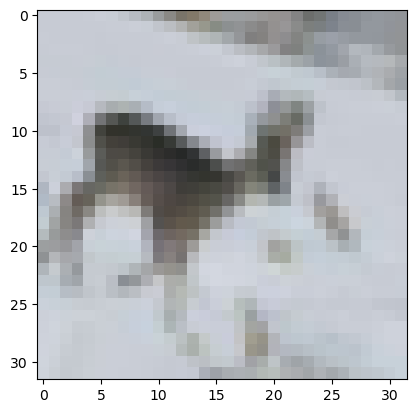

In [41]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creates a data generator object that transforms images
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')


# pick an image to transform
test_img = train_images[20]
img = image.img_to_array(test_img)  # convert image to numpy arry
img = img.reshape((1,) + img.shape)  # reshape image



i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i > 4:  # show 4 images
        break

plt.show()

The above is a good way to increase the size of a dataset, but what if even after that we do not have enough images in our dataset? We can use something called **pretrained models**

When we employ the technique defined above, we will often want to tweak the final layers in our convolutional base to work better for our specific problem. This involves not touching or retraining the earlier layers in our convolutional base but only adjusting the final few. We do this because the first layers in our base are very good at extracting low level features lile lines and edges, things that are similar for any kind of image. Where the later layers are better at picking up very specific features like shapes or even eyes. If we adjust the final layers than we can look for only features relevant to our very specific problem.

The following is a resource to look into Tenserflows object detection API

https://github.com/tensorflow/models/tree/master/research/object_detection